# HW 13
### Thomas Atkins, Chris Dailey, Sam Kahn

## 13.1
Write a basic Spark implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input.
Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]

In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.

In [4]:
# import findspark
import time
import matplotlib.pyplot as plt
# import os
# import sys

# os.environ['SPARK_HOME'] = '/usr/lib/spark/'
# findspark.init()

In [5]:
%matplotlib inline

In [1]:
from pyspark import SparkConf, SparkContext

In [2]:
# not needed if started from pyspark
# conf = SparkConf().setMaster('spark://172.31.3.63:58546').setAppName('test2')
# sc = SparkContext(conf = conf)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=PySparkShell, master=yarn-client) created by <module> at /home/hadoop/miniconda2/envs/261-env/lib/python2.7/site-packages/IPython/utils/py3compat.py:288 

In [3]:
sc

In [4]:
!cat ./PageRank-test.txt

B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}


In [6]:
# mapCount is for counting the true number of nodes
# necessary since nodes with no outgoing links are not listed on their own line

def mapCount(entry):
    yield (str(entry[0]), 1)
    for key, value in entry[1].items():
        yield (key, 1)
        
# processLine turns the string into python objects,
# specifically the label and a dictionary of edges.
# this assumes zero formatting errors
def processLine(line):
    splits = line.strip().split('\t')
    return [splits[0], eval(splits[1])]

# prep_map generates a line for each possible node, including nodes that exist
# only in the edge dictionary of another node
def prep_map(entry):
    nodeID = entry[0]
    edges = entry[1]
    for edge, weight in edges.items():
        yield (str(edge.strip()), {})
    yield (str(nodeID), edges)
    
# prep_reduce combines the dictionaries of the records created in the map phase
def prep_reduce(x, y):
    edges = {}
    for key, value in x.items():
        edges[key] = value
    for key, value in y.items():
        edges[key] = value
    return edges

# init_entry distributes the initial probability mass
# it also adds a value into the record of 0.0 which will eventually represent
# the amount of change in that node's probability mass
# which we'll use to check for convergence
# it is reliant on the accum_total_pr accumulator for its closure

accum_total_pr = sc.accumulator(0.0)

def init_entry(entry):
    accum_total_pr.add(1.0 / broadcast_nodecount.value)
    return (entry[0], [entry[1], 1.0 / broadcast_nodecount.value, 0.0]) #the 0.0 is the delta pr 


# Phase one consists of a map and reducebykey phase.
# phaseOneMapper stores the pr mass of the node as it is as the beginning of the step
# if there are no outgoing edges, it passes all the pr mass of that node to the dangling_mass accumulator
# which is defined here for the closure.
# if there are edges, it divides the pr mass evenly among them and emits the target node with 
# an empty edge list and a zero previous pr mass.  This is done so that when records are combined
# in the reduce step, there will be exactly one record with a full edge list and an accurate
# previous pr mass, so we can cummutatively and associatively add the records together
# and arrive at a single accurate record

accum_dangling_mass = sc.accumulator(0.0)


def phaseOneMapper(entry):
    label = entry[0]
    edges = entry[1][0]
    pr = entry[1][1]
    previous = pr

    if len(edges) == 0:
        accum_dangling_mass.add(pr)
    else:
        forwarding_pr = pr / len(edges)
        for edge, weight in edges.items():
            yield (edge, [{}, forwarding_pr, 0.0])
    yield (label, [edges, 0.0, pr])

def phaseOneReducer(x, y):
    edges = {}
    for edge, weight in x[0].items():
        edges[edge] = weight
    for edge, weight in y[0].items():
        edges[edge] = weight
    return [edges, x[1] + y[1], x[2] + y[2]]

# the finalize state distributes the dangling pr mass by knowing from the broadcast variables how many
# nodes there are and by being passed the dangling mass from a variable defined with the accumulator
# in the driver program logic.  It also calculates the final pr mass of the node by the pagerank equation
# additionally, it records the absolute value of how much the pr mass of this node has changed and
# passes it to the accum_moved_mass accumulator.  
# Since the original pr mass value is no longer needed, it is not stored
# (recall that it is regenerated in the phase one map step and is simply the value here called pr_prime)

accum_moved_mass = sc.accumulator(0.0)

def finalize(entry, dangling_mass):
    label = str(entry[0])
    edges = entry[1][0]
    pr = entry[1][1]
    previous = entry[1][2]
    
    pr_prime = broadcast_damping_factor.value * (1.0 / broadcast_nodecount.value) + \
    (1 - broadcast_damping_factor.value) * (dangling_mass / broadcast_nodecount.value + pr)
    
    accum_moved_mass.add(((pr_prime - previous)**2)**.5)
    
    return (label, [edges, pr_prime])

    

There are 15192277 nodes in the dataset
(151.244594812)

Data prepped
(260.411257029)

Initial dangling mass: 0.0
Dangling mass distributed
(13.2362689972)

Iteration 1 runtime: 400.080931187
Iteration 2 runtime: 564.145447016
Iteration 3 runtime: 468.505146027
Iteration 4 runtime: 531.949018955




Results:

Iterations: 4
Runtime: 2389.61063194
Moved mass on final iteration: 0.000552358975626
Total pr :1.0


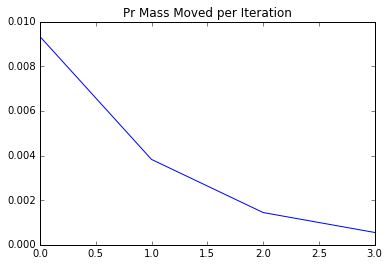

In [19]:
verbose = False

#load the data and process it
data = sc.textFile("/data/all-pages-indexed-out.txt").map(processLine).repartition(50).cache()
# data = sc.textFile("/data/PageRank-test.txt").map(processLine)

overall_start_time = time.time()

# count the true number of nodes
start_time = time.time()
nodecount = data.flatMap(mapCount).reduceByKey(lambda x, y: 1).count()
nodecount_time = time.time() - start_time
broadcast_nodecount = sc.broadcast(nodecount)

print "There are " + str(broadcast_nodecount.value) + " nodes in the dataset"
print "(" + str(nodecount_time) + ")\n"

# conduct the initial preparations
prepped_data = data.flatMap(prep_map).reduceByKey(prep_reduce).map(init_entry)

broadcast_damping_factor = sc.broadcast(.15)

accum_dangling_mass = sc.accumulator(0.0)
accum_moved_mass = sc.accumulator(1.0)
accum_total_pr = sc.accumulator(0.0)

# conduct one initial pass
start_time = time.time()
prepped_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer).cache()
prepped_data.take(1)
prep_time = time.time() - start_time
print "Data prepped"
print "(" + str(prep_time) + ")\n"

dangling_mass = accum_dangling_mass.value

print "Initial dangling mass: " + str(dangling_mass)

start_time = time.time()
intermediate_data = prepped_data.map(lambda x: finalize(x, dangling_mass)).cache()
intermediate_data.take(1)
distribute_time = time.time() - start_time
print "Dangling mass distributed"
print "(" + str(distribute_time) + ")\n"


# loop until converged byt checking how much pr mass has moved.

deltas = []
i = 0
# while accum_moved_mass.value >= .001 and i < 40:
for i in range(50):
#     i += 1
    if verbose:
        print "Iteration: " + str(i)
    accum_dangling_mass = sc.accumulator(0.0)
    accum_moved_mass = sc.accumulator(0.0)
    
    iteration_start_time = time.time()

    intermediate_data = intermediate_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer)
    intermediate_data.cache()
    intermediate_data.take(1)
    
    
    dangling_mass = accum_dangling_mass.value
    if verbose:
        print "Total dangling mass: " + str(dangling_mass)

    intermediate_data = intermediate_data.map(lambda x: finalize(x, dangling_mass))
    intermediate_data.cache()
    intermediate_data.take(1)
    if verbose:
        print "Moved mass: " + str(accum_moved_mass.value) 
        print "Total pr: " + str(intermediate_data.map(lambda x: x[1][1]).reduce(lambda x, y: x + y)) + "\n"
    deltas.append(accum_moved_mass.value)
    iteration_runtime = time.time() - iteration_start_time
    print "Iteration " + str(i) + " runtime: " + str(iteration_runtime) 
    
overall_runtime = time.time() - overall_start_time
    
#report results

print "\n\n\n"
print "Results:\n"
print "Iterations: " + str(i)
print "Runtime: " + str(overall_runtime)
print "Moved mass on final iteration: " + str(accum_moved_mass.value)
print "Total pr :" + str(intermediate_data.map(lambda x: x[1][1]).reduce(lambda x, y: x+y))
plt.title("Pr Mass Moved per Iteration")
plt.plot(deltas)




In [ ]:
# target values:
# A,0.033
# B,0.384
# C,0.343
# D,0.039
# E,0.081
# F,0.039
# G,0.016
# H,0.016
# I,0.016
# J,0.016
# K,0.016

In [12]:
intermediate_data.collect()

[('A', [{}, 0.03278149316544258]),
 ('C', [{'B': 1}, 0.34312940441040823]),
 ('B', [{'C': 1}, 0.3841818298763775]),
 ('E', [{'B': 1, 'D': 1, 'F': 1}, 0.08088569324541087]),
 ('D', [{'A': 1, 'B': 1}, 0.03908709210678531]),
 ('G', [{'B': 1, 'E': 1}, 0.016169479017757935]),
 ('F', [{'B': 1, 'E': 1}, 0.03908709210678531]),
 ('I', [{'B': 1, 'E': 1}, 0.016169479017757935]),
 ('H', [{'B': 1, 'E': 1}, 0.016169479017757935]),
 ('K', [{'E': 1}, 0.016169479017757935]),
 ('J', [{'E': 1}, 0.016169479017757935])]

In [22]:
def PageRank(filename, repartition = True, verbose = False):

    verbose = False

    #load the data and process it
#     data = sc.textFile("/data/all-pages-indexed-out.txt").map(processLine).repartition(50).cache()
    # data = sc.textFile("/data/PageRank-test.txt").map(processLine)
    if repartition:
        data = sc.textFile(filename).map(processLine).repartition(50).cache()
    else:
        data = sc.textFile(filename).map(processLine).cache()

    overall_start_time = time.time()

    # count the true number of nodes
    start_time = time.time()
    nodecount = data.flatMap(mapCount).reduceByKey(lambda x, y: 1).count()
    nodecount_time = time.time() - start_time
    broadcast_nodecount = sc.broadcast(nodecount)

    print "There are " + str(broadcast_nodecount.value) + " nodes in the dataset"
    print "(" + str(nodecount_time) + ")\n"

    # conduct the initial preparations
    prepped_data = data.flatMap(prep_map).reduceByKey(prep_reduce).map(init_entry)

    broadcast_damping_factor = sc.broadcast(.15)

    accum_dangling_mass = sc.accumulator(0.0)
    accum_moved_mass = sc.accumulator(1.0)
    accum_total_pr = sc.accumulator(0.0)

    # conduct one initial pass
    start_time = time.time()
    prepped_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer).cache()
    prepped_data.take(1)
    prep_time = time.time() - start_time
    print "Data prepped"
    print "(" + str(prep_time) + ")\n"

    dangling_mass = accum_dangling_mass.value

    print "Initial dangling mass: " + str(dangling_mass)

    start_time = time.time()
    intermediate_data = prepped_data.map(lambda x: finalize(x, dangling_mass)).cache()
    intermediate_data.take(1)
    distribute_time = time.time() - start_time
    print "Dangling mass distributed"
    print "(" + str(distribute_time) + ")\n"


    # loop until converged byt checking how much pr mass has moved.

    deltas = []
    i = 0
    # while accum_moved_mass.value >= .001 and i < 40:
    for i in range(50):
    #     i += 1
        if verbose:
            print "Iteration: " + str(i)
        accum_dangling_mass = sc.accumulator(0.0)
        accum_moved_mass = sc.accumulator(0.0)

        iteration_start_time = time.time()

        intermediate_data = intermediate_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer)
        intermediate_data.cache()
        intermediate_data.take(1)


        dangling_mass = accum_dangling_mass.value
        if verbose:
            print "Total dangling mass: " + str(dangling_mass)

        intermediate_data = intermediate_data.map(lambda x: finalize(x, dangling_mass))
        intermediate_data.cache()
        intermediate_data.take(1)
        if verbose:
            print "Moved mass: " + str(accum_moved_mass.value) 
            print "Total pr: " + str(intermediate_data.map(lambda x: x[1][1]).reduce(lambda x, y: x + y)) + "\n"
        deltas.append(accum_moved_mass.value)
        iteration_runtime = time.time() - iteration_start_time
        print "Iteration " + str(i) + " runtime: " + str(iteration_runtime) 

    overall_runtime = time.time() - overall_start_time

    #report results

    print "\n\n\n"
    print "Results:\n"
    print "Iterations: " + str(i)
    print "Runtime: " + str(overall_runtime)
    print "Moved mass on final iteration: " + str(accum_moved_mass.value)
    print "Total pr :" + str(intermediate_data.map(lambda x: x[1][1]).reduce(lambda x, y: x+y))
    plt.title("Pr Mass Moved per Iteration")
    plt.plot(deltas)




There are 11 nodes in the dataset
(0.234357833862)

Data prepped
(0.133213996887)

Initial dangling mass: 0.0
Dangling mass distributed
(0.104043960571)

Iteration 0 runtime: 0.307657003403
Iteration 1 runtime: 0.392288923264
Iteration 2 runtime: 0.34707903862
Iteration 3 runtime: 0.356085062027
Iteration 4 runtime: 0.343777179718
Iteration 5 runtime: 0.3557741642
Iteration 6 runtime: 0.343940973282
Iteration 7 runtime: 0.359601020813
Iteration 8 runtime: 0.347985982895
Iteration 9 runtime: 0.355764865875
Iteration 10 runtime: 0.36382317543
Iteration 11 runtime: 0.355926990509
Iteration 12 runtime: 0.343904972076
Iteration 13 runtime: 0.383816003799
Iteration 14 runtime: 0.348067045212
Iteration 15 runtime: 0.363799095154
Iteration 16 runtime: 0.347794771194
Iteration 17 runtime: 0.367953062057
Iteration 18 runtime: 0.347496032715
Iteration 19 runtime: 0.355754137039
Iteration 20 runtime: 0.355785131454
Iteration 21 runtime: 0.360646009445
Iteration 22 runtime: 0.363996982574
Iteration

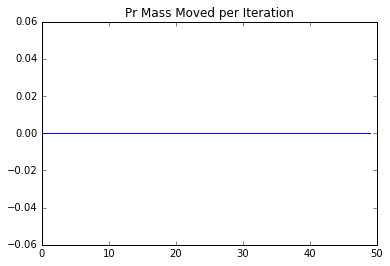

In [23]:
PageRank("/data/PageRank-test.txt", repartition = False)

In [17]:
!hdfs dfs -cat /data/PageRank-test.txt

B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}
